# Repeated measurements on Starmon-5 -- Analysis

In [15]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import itertools as it

import qiskit.tools.jupyter
import qiskit.tools.visualization as qvis # circuit_drawer, plot_histogram

from importlib import reload
import inspire_experiments
reload(inspire_experiments)
from inspire_experiments import ExperimentData, get_starmon_status, inspire_login, get_file_header, measure_readout_correction
from inspire_experiments.analysis_tools import *

# matplotlib.style.use('ggplot')
# matplotlib.style.use('seaborn')
# %matplotlib notebook
%qiskit_version_table

In [10]:
api, backend = inspire_login()
backend.status()

Backend status:  IDLE


In [11]:

get_starmon_status(api)

'IDLE'

## Entaglement by msmt


### Readout correction

In [12]:
# qubits = [1, 2, 3]
# tomo_qubits = [1, 3]
qubits = [0, 2, 4]
tomo_qubits = [0, 4]
sim_msmt = False
exp_name = "entanglement_by_msmt_qbs"
exp_name = exp_name + str(qubits) + f"_tom{tomo_qubits}"
# exp_name = exp_name + "_sim-msmt" if sim_msmt else exp_name
print(exp_name)

entanglement_by_msmt_qbs[0, 2, 4]_tom[0, 4]


In [13]:
shots_dict = {qb: {} for qb in tomo_qubits}
for state in [''.join(s) for s in it.product(['0', '1'], repeat=2)]:
    print(state)
    bitstrings = ExperimentData.get_csv_data(f"readout_correction_qbs{tomo_qubits}_state{state}_RAW.csv")
    pprint(bitstrings)
    for qb in shots_dict.keys():
        shots_dict[qb][state] = np.array(list(map(lambda s: int(s[-1-qb]), bitstrings)))
shots_dict

00
array(['00000', '00000', '00000', ..., '00000', '00000', '00000'],
      dtype='<U5')
01
array(['00001', '00001', '00001', ..., '00001', '00001', '00001'],
      dtype='<U5')
10
array(['00001', '00001', '00001', ..., '00000', '00001', '00001'],
      dtype='<U5')
11
array(['00001', '00001', '00001', ..., '00001', '00001', '00001'],
      dtype='<U5')


{0: {'00': array([0, 0, 0, ..., 0, 0, 0]),
  '01': array([1, 1, 1, ..., 1, 1, 1]),
  '10': array([1, 1, 1, ..., 0, 1, 1]),
  '11': array([1, 1, 1, ..., 1, 1, 1])},
 4: {'00': array([0, 0, 0, ..., 0, 0, 0]),
  '01': array([0, 0, 0, ..., 0, 0, 0]),
  '10': array([0, 0, 0, ..., 0, 0, 0]),
  '11': array([0, 0, 0, ..., 0, 0, 0])}}

In [26]:
(shots_dict[1]['11'] == shots_dict[3]['11']).all()

False

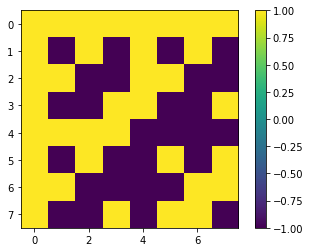

In [99]:
plt.imshow(sp.linalg.pinv(gen_M_matrix(3)))
plt.colorbar()

In [16]:
beta = get_Beta_matrix(shots_dict, 2)
beta

{'IZ': array([0., 0., 0., 0.]),
 'ZI': array([ 0.73439026, -0.24531555, -0.2124176 , -0.19816589]),
 'ZZ': array([0., 0., 0., 0.])}

### Tomography data

In [35]:
print(gen_gate_order(2))

['ZZ' 'XZ' 'YZ' 'ZX' 'XX' 'YX' 'ZY' 'XY' 'YY']


In [59]:
# masks_0 = np.empty((len(gen_gate_order(2)), 2**14))
# masks_1 = np.empty((len(gen_gate_order(2)), 2**14))
gate_order = gen_gate_order(2)
masks_0 = [None] * len(gate_order)
masks_1 = [None] * len(gate_order)

tomo_shots_dict = {qb: {} for qb in tomo_qubits}

for i, tomo_state in enumerate(gate_order):
    print(tomo_state)
    filename = exp_name + f"_M{tuple(tomo_state)}" + "_sim-msmt" if sim_msmt else exp_name + f"_M{tuple(tomo_state)}"
    bitstrings = get_csv_data(filename + "_RAW.csv")
    # print(bitstrings)
    if sim_msmt:
        # for simultaneous msmt
        mask_bits = bitstrings
        tomo_bits = bitstrings
    else:
        # for sequential msmt
        mask_bits = bitstrings[0]
        tomo_bits = bitstrings[1]

    # create masks for postselection on state of middle (ancilla) qubit
    masks_0[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 0, 1, np.nan)
    masks_1[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 1, 1, np.nan)

    # create dict for shots by qubit, per tomo_state
    for qb in shots_dict.keys():
        tomo_shots_dict[qb][tomo_state] = np.array(list(map(lambda s: int(s[-1-qb]), tomo_bits)))

tomo_shots_dict

ZZ
XZ
YZ
ZX
XX
YX
ZY
XY
YY


{1: {'ZZ': array([0, 1, 0, ..., 0, 1, 0]),
  'XZ': array([0, 1, 1, ..., 1, 0, 1]),
  'YZ': array([1, 0, 1, ..., 0, 0, 1]),
  'ZX': array([0, 0, 0, ..., 0, 0, 0]),
  'XX': array([0, 0, 1, ..., 1, 0, 1]),
  'YX': array([0, 1, 1, ..., 0, 1, 0]),
  'ZY': array([0, 0, 0, ..., 0, 1, 0]),
  'XY': array([1, 1, 1, ..., 0, 1, 1]),
  'YY': array([0, 0, 0, ..., 0, 0, 1])},
 3: {'ZZ': array([0, 1, 0, ..., 0, 0, 0]),
  'XZ': array([0, 0, 1, ..., 1, 1, 1]),
  'YZ': array([1, 0, 1, ..., 1, 0, 0]),
  'ZX': array([0, 1, 1, ..., 0, 0, 0]),
  'XX': array([1, 0, 1, ..., 0, 0, 1]),
  'YX': array([0, 1, 0, ..., 1, 0, 0]),
  'ZY': array([0, 1, 0, ..., 1, 0, 1]),
  'XY': array([1, 0, 0, ..., 1, 0, 0]),
  'YY': array([0, 1, 0, ..., 1, 1, 1])}}

### Results

In [60]:
Pauli_terms_0, rho_0, P_frac_0 = get_Pauli_expectation_values(beta, gate_order, masks_0,
                                                              Tomo_shots_dig=tomo_shots_dict)
Pauli_terms_1, rho_1, P_frac_1 = get_Pauli_expectation_values(beta, gate_order, masks_1,
                                                              Tomo_shots_dig=tomo_shots_dict)

In [53]:
rho_1

array([[ 0.30526789+0.j        , -0.01551226+0.04027882j,
         0.00998525+0.02305328j, -0.16542798-0.01762581j],
       [-0.01551226-0.04027882j,  0.22669379+0.j        ,
         0.03559731+0.02208802j,  0.05859308-0.01259478j],
       [ 0.00998525-0.02305328j,  0.03559731-0.02208802j,
         0.20714041+0.j        ,  0.04651135-0.00959996j],
       [-0.16542798+0.01762581j,  0.05859308+0.01259478j,
         0.04651135+0.00959996j,  0.26089791+0.j        ]])

In [54]:
np.allclose(list(map(np.trace, [rho_1, rho_0])), 1.0)

True

In [61]:
np.abs(rho_0) <= 0.5

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

### Plotting

In [56]:
R_0 = np.zeros(rho_0.shape)
R_0[ 0, 0] = 0.5
R_0[ 0,-1] = 0.5
R_0[-1, 0] = 0.5
R_0[-1,-1] = 0.5

fid_0 = fidelity(rho_0, R_0)
fid_1 = fidelity(rho_1, R_0)
angle_0 = np.angle(rho_0[0,-1])*180/np.pi
angle_1 = np.angle(rho_1[0,-1])*180/np.pi
ps_frac_0 = np.mean(list(P_frac_0.values()))
ps_frac_1 = np.mean(list(P_frac_1.values()))
n_shots = len(tomo_shots_dict[1]['ZZ'])
print(fid_0, fid_1, angle_0, angle_1, ps_frac_0, ps_frac_1)

0.04249933982823206 0.11765491831351751 142.68604978580146 -173.9182682572741 0.4988670349121094 0.5011329650878906


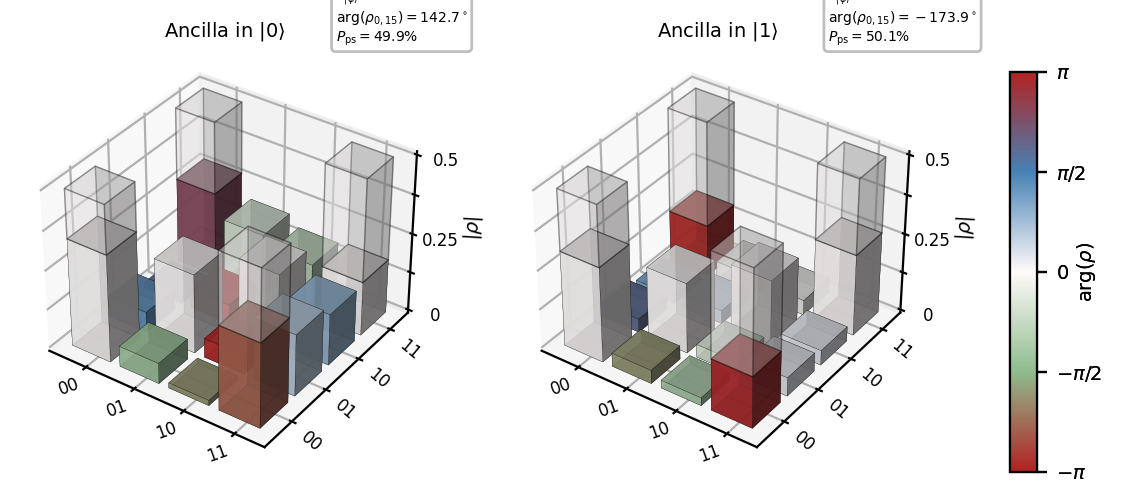

In [57]:
fig = plt.figure(figsize=(9, 8), dpi = 200)
# fig.subplots_adjust(0,0,1,1)
ax = fig.add_subplot(131, projection='3d', azim=-55, elev=35)
ax2 = fig.add_subplot(132, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho_0, ax, rho_id=R_0, title=r"Ancilla in $\vert 0 \rangle$", fidelity=fid_0, ps_frac=ps_frac_0, angle=angle_0)
plot_density_matrix(rho_1, ax2, rho_id=R_0, title=r"Ancilla in $\vert 1 \rangle$", fidelity=fid_1, ps_frac=ps_frac_1, angle=angle_1)
filename = exp_name + "_sim-msmt" + "_PLOT.png" if sim_msmt else exp_name + "_PLOT.png"
fig.savefig(DATA_DIR + filename, format='png', dpi=200)

0.5706187552933286 0.12420473253336199 -20.312301688053957 0.369108593503929 0.5069007873535156 0.4930992126464844


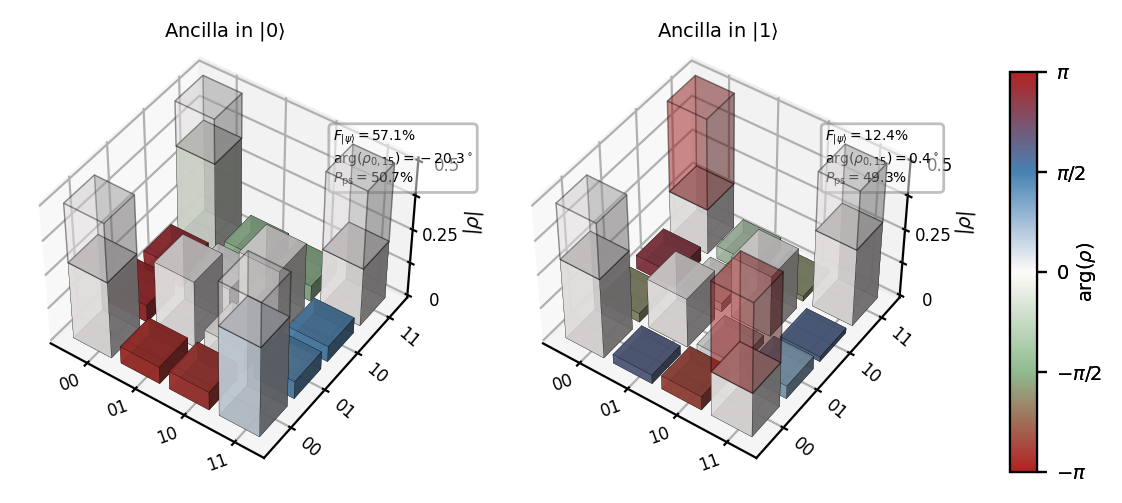

In [70]:
R_0 = np.zeros(rho_0.shape)
R_0[ 0, 0] = 0.5
R_0[ 0,-1] = 0.5
R_0[-1, 0] = 0.5
R_0[-1,-1] = 0.5

R_1 = np.zeros(rho_1.shape)
R_1[ 0, 0] = 0.5
R_1[ 0,-1] = -0.5
R_1[-1, 0] = -0.5
R_1[-1,-1] = 0.5

fid_0 = fidelity(rho_0, R_0)
fid_1 = fidelity(rho_1, R_1)
angle_0 = np.angle(rho_0[0,-1])*180/np.pi
angle_1 = np.angle(rho_1[0,-1])*180/np.pi
ps_frac_0 = np.mean(list(P_frac_0.values()))
ps_frac_1 = np.mean(list(P_frac_1.values()))
n_shots = len(tomo_shots_dict[1]['ZZ'])
print(fid_0, fid_1, angle_0, angle_1, ps_frac_0, ps_frac_1)

fig = plt.figure(figsize=(9, 8), dpi = 200)
# fig.subplots_adjust(0,0,1,1)
ax = fig.add_subplot(131, projection='3d', azim=-55, elev=45)
ax2 = fig.add_subplot(132, projection='3d', azim=-55, elev=45)
plot_density_matrix(rho_0, ax, rho_id=R_0, title=r"Ancilla in $\vert 0 \rangle$", fidelity=fid_0, ps_frac=ps_frac_0, angle=angle_0)
plot_density_matrix(rho_1, ax2, rho_id=R_1, title=r"Ancilla in $\vert 1 \rangle$", fidelity=fid_1, ps_frac=ps_frac_1, angle=angle_1)
filename = exp_name + "_sim-msmt" + "_PLOT.png" if sim_msmt else exp_name + "_PLOT.png"
# fig.savefig(DATA_DIR + filename, format='png', dpi=200)

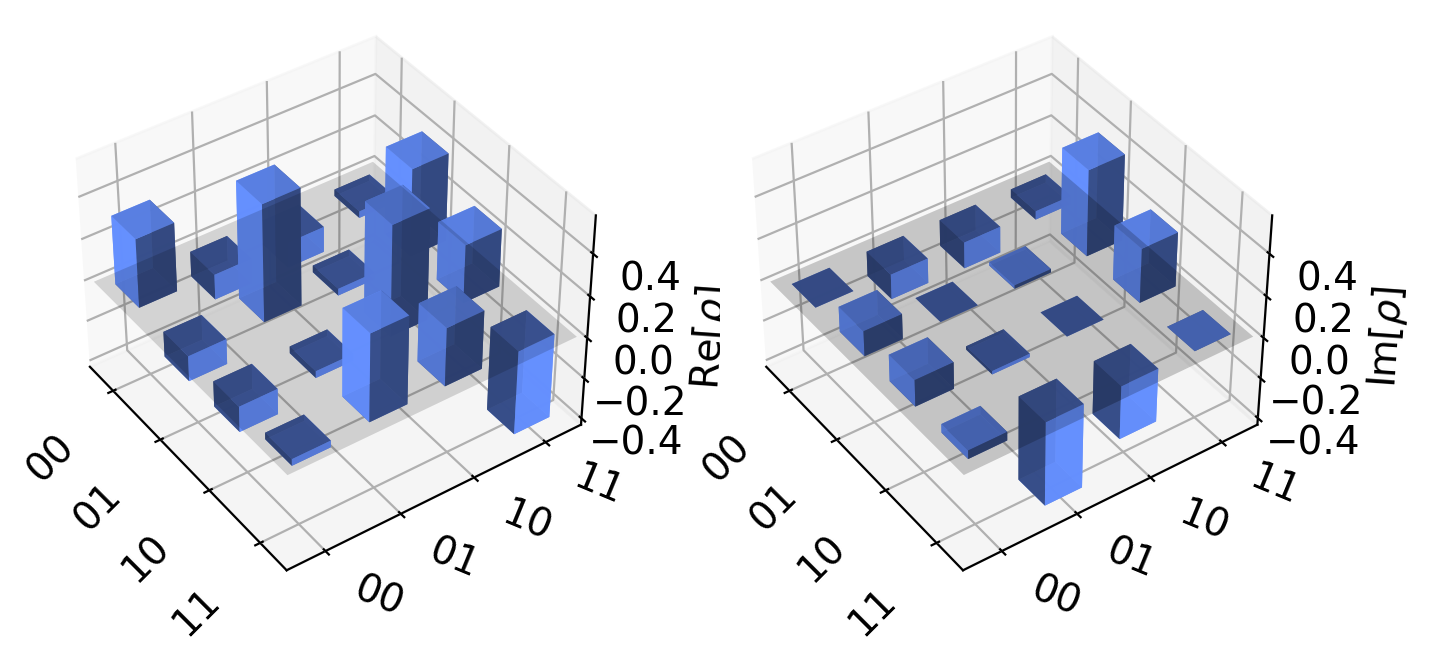

In [69]:
fig = plt.figure(figsize=(8, 8), dpi=200)
ax1 = fig.add_subplot(121, projection='3d', azim=-35, elev=40)
ax2 = fig.add_subplot(122, projection='3d', azim=-35, elev=40)
qvis.plot_state_city(rho_0, alpha=0.9, ax_real=ax1, ax_imag=ax2)
filename = exp_name + "_sim-msmt" + "_PLOT2.png" if sim_msmt else exp_name + "_PLOT2.png"
fig.savefig(DATA_DIR + filename, format='png', dpi=200)

# Testing

In [75]:
qubits = [1,2,3]
data_hex = np.loadtxt(DATA_DIR + "entanglement_by_msmt_qbs[1, 2, 3]_tom[1, 3]_M('Z', 'Z')_RAW.csv", comments='#', dtype='<U3', delimiter=',')

# data_bin = np.array(["{0:05b}".format(b) for b in list(map(lambda d: int(d, 16), data_hex.flatten()))]).reshape(data_hex.shape) #int(data_hex, 16))
# np.apply_over_axes(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex, data_hex.shape)
data_bin = np.array(list(map(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex.flatten()))).reshape(data_hex.shape)
# np.take(data_bin[1,0], qubits)
np.fromstring(data_bin[0,0])

/tmp/ipykernel_8820/1087478125.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  np.fromstring(data_bin[0,0])


ValueError: string size must be a multiple of element size

In [7]:
exp_name = "entaglement_via_msmt_qubits_[1,2,3]"
results = get_json_data(exp_name + "_PROB.json")
results

[{'00000': 0.204345703125,
  '00010': 0.09130859375,
  '00100': 0.19244384765625,
  '00110': 0.09600830078125,
  '01000': 0.05621337890625,
  '01010': 0.14300537109375,
  '01100': 0.06707763671875,
  '01110': 0.14959716796875}]

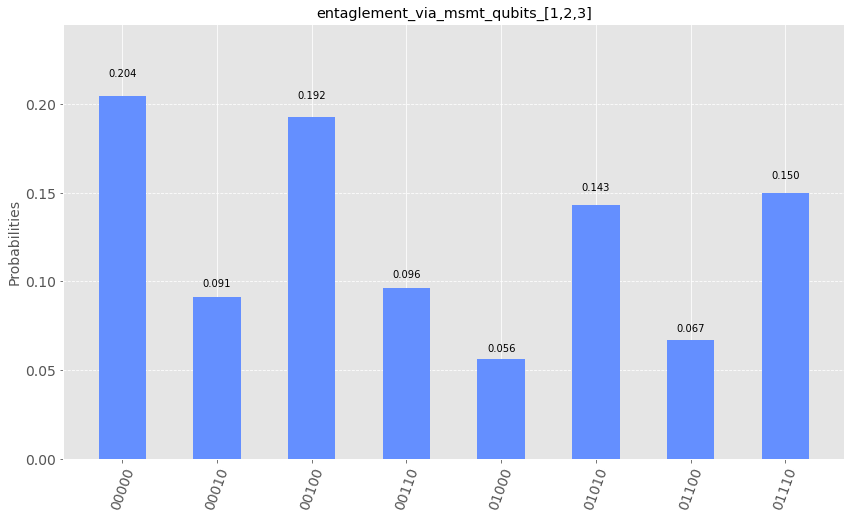

In [16]:
qvis.plot_histogram(results,
               title=exp_name,
               # filename="./data/" + exp_name + '_HIST' + '.png',
               # legend=[f"msmt {i}" for i in range(N)],
               figsize=(14,8))


In [17]:
exp_name = "entaglement_via_msmt_qubits_[1,2,3]_with_IDs"
results = get_json_data(exp_name + "_PROB.json")
results


[{'00000': 0.21929931640625,
  '00010': 0.09002685546875,
  '00100': 0.20880126953125,
  '00110': 0.09588623046875,
  '01000': 0.06439208984375,
  '01010': 0.11749267578125,
  '01100': 0.073974609375,
  '01110': 0.130126953125}]

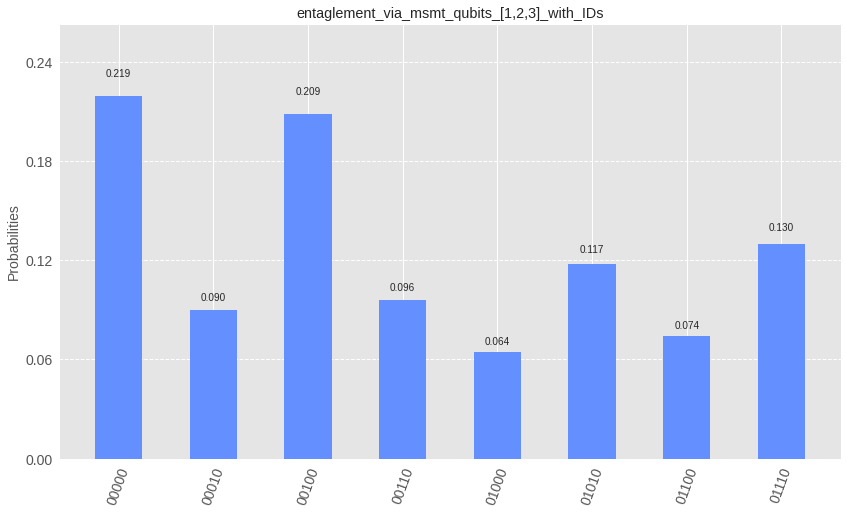

In [26]:
qvis.plot_histogram(results,
               title=exp_name,
               # filename="./data/" + exp_name + '_HIST' + '.png',
               # legend=[f"msmt {i}" for i in range(N)],
               figsize=(14,8))
